# Research Question 5: Property Market Segmentation in Surat

## 1. Question Statement and Motivation

**Question**: Can clustering techniques identify meaningful groups of properties such as affordable low-rise resale units, luxury high-rise new developments, and mid-range family apartments?

The question is worth investigating because the real estate market is heterogeneous. Properties differ not only in price but also in physical structure, vertical position, and intended buyer segment. Simple averages hide these differences

By answering this question, we can:
- Discover natural groupings without predefined labels
- Understand how price, height, and size jointly shape market segments

There are several targets that care about this analysis:
- **Home buyers**: choose properties aligned with budget and preferences
- **Investors**: tailor pricing and marketing

## 2. Preprocess 

Here is my summarized preprocess:
- Data Inspection: Double check the dataset we read
- Numerical Converting: As I check the floor feature is still Object so we need to convert them into numerical for modeling
- Feature Scaling: We need to scale down because the ``price_per_sqft`` is extremely larger than any other features

### 2.1 Data Inspection

We first loading the necessary libraries as well as loading the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = np.load("../data/processed/surat_cleaned.npy", allow_pickle=True)
df = pd.DataFrame(df)

We only focus on structural and pricing features so we need to filter them at first
Candidate features:
- ``square_feet``
- ``floor``
- ``num_floor``
- ``price_per_sqft``
- ``bhk`` 

In [3]:
cluster_features = [
    "square_feet",
    "floor",
    "num_floor",
    "price_per_sqft",
    "bhk"
]

df_cluster = df[cluster_features].copy()

We then inspect the new data frame we create at first before moving on to the next step

In [4]:
df_cluster.head()

,square_feet,floor,num_floor,price_per_sqft,bhk
0,644.0,5,10,2891.0,2.0
1,1278.0,6,14,3551.0,2.0
2,1173.0,5,13,3800.0,2.0
3,700.0,6,14,3966.0,2.0
4,720.0,3,14,3200.0,2.0


In [5]:
df_cluster.describe()

,square_feet,price_per_sqft,bhk
count,3.003000e+03,3003.000000,3003.00000
mean,3.299283e+03,5284.669331,2.85681
std,7.668272e+04,7054.589076,1.05423
min,3.000000e+00,4.000000,1.00000
25%,1.000000e+03,3611.000000,2.00000
50%,1.400000e+03,4500.000000,3.00000
75%,2.202000e+03,5636.000000,3.00000
max,4.198405e+06,194444.000000,10.00000


### 2.2 Numerical Converting

In [6]:
for col in cluster_features:
    df_cluster[col] = pd.to_numeric(df_cluster[col], errors="coerce")

df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   square_feet     3003 non-null   float64
 1   floor           3003 non-null   int64  
 2   num_floor       3003 non-null   int64  
 3   price_per_sqft  3003 non-null   float64
 4   bhk             3003 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 117.4 KB


In [7]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
        
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cluster = remove_outliers_iqr(df_cluster, 'price_per_sqft')

### 2.3 Feature Scaling

There are many features have larger range than ``floor`` for example ``price_per_sqft`` or ``num_floor`` so it is better to scale down those features

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

X_scaled[:5]

array([[-0.80786339, -0.15417287, -0.13818005, -1.20007917, -0.80393549],
       [-0.36521021,  0.1560199 ,  0.78302028, -0.72410356, -0.80393549],
       [-0.43852028, -0.15417287,  0.5527202 , -0.54453095, -0.80393549],
       [-0.76876468,  0.1560199 ,  0.78302028, -0.42481587, -0.80393549],
       [-0.75480086, -0.77455839,  0.78302028, -0.97723605, -0.80393549]])

## 3. Analysis

### 3.1 Elbow Method

Firstly, we need to use the Elbow method to choose the proper value of k

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 9)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

As the illustration below, there is a significant decrease from k = 2 to k = 3 which is what we expect. There might be three types of meaningful market segments: Budget Resale, Mid-range Family, High-rise Luxury

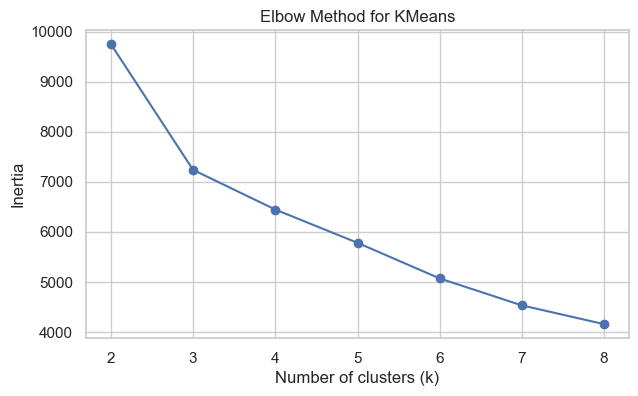

In [10]:
plt.figure(figsize=(7, 4))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()

### 3.2 K-Mean Clustering

We then apply the K-Mean algorithm to the value of k=3, and hopefully it can captures the markets as we expect it to be

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_cluster["cluster"] = cluster_labels

In [12]:
df.loc[df_cluster.index, "cluster"] = cluster_labels
df["cluster"].value_counts()

cluster
1.0    1513
0.0     756
2.0     586
Name: count, dtype: int64

### 3.3 Clustering Overall Analysis

To verify the market clusters, we need to double check the price, height, area in every clusters by using boxplot

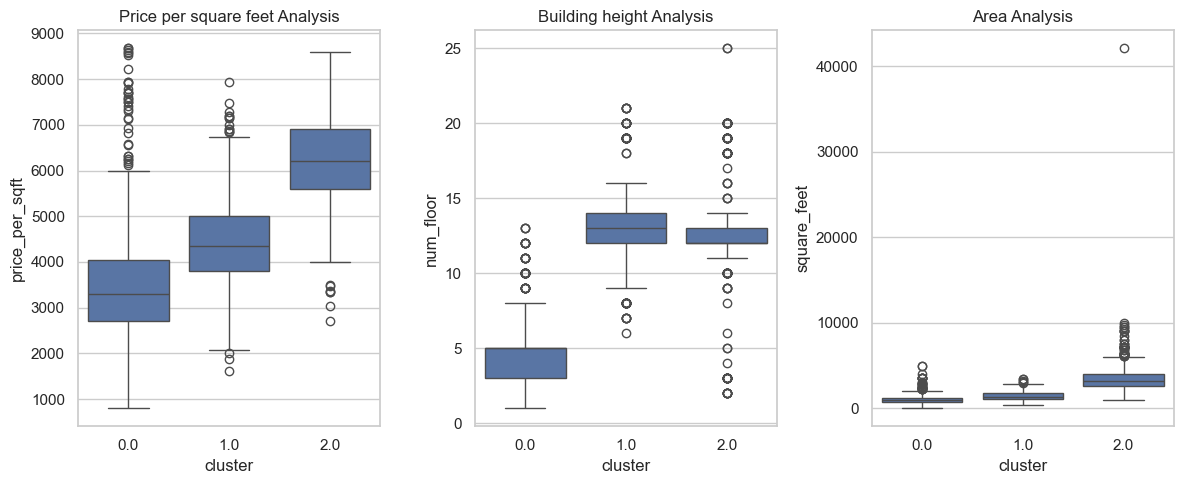

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='cluster', y='price_per_sqft', data=df)
plt.title('Price per square feet Analysis')

plt.subplot(1, 3, 2)
sns.boxplot(x='cluster', y='num_floor', data=df)
plt.title('Building height Analysis')

plt.subplot(1, 3, 3)
sns.boxplot(x='cluster', y='square_feet', data=df)
plt.title('Area Analysis')

plt.tight_layout()
plt.show()

In [21]:
cluster_summary = (
    df.groupby("cluster")[cluster_features]
    .mean()
    .round(2)
)

cluster_summary

,square_feet,floor,num_floor,price_per_sqft,bhk
cluster,,,,,
0.0,1060.89,2.242063,4.456349,3518.47,2.12
1.0,1469.48,6.797753,12.8731,4419.80,2.65
2.0,3612.18,6.337884,12.656997,6241.58,4.15


- Cluster 0: "Affordable Low-rise"
    - Price: Lowest median price (~3,300/sqft).
    - Height: Characterized strictly by low-rise structures, with a median height of 4-5 floors. Most units are situated below the 6th floor.
    - Area: Smallest and most compact distribution (~1,000 sqft).
- Cluster 1: "Standard Mid-rise"
    - Price: Mid-range pricing (Median ~4,300/sqft), clearly distinguishing itself from the budget segment.
    - Height: Exhibits a very tight clustering around 13-14 floors. The narrow box suggests a standardized building height for commercial mid-range developments.
    - Area: Standard family-sized units (approx. 1,200 - 1,400 sqft), typical for 2-3 BHK apartments.
- Cluster 2: "Premium Large-format"
    - Price: Highest price point (Median ~6,200/sqft) with significant variance.
    - Height: Wide distribution, encompassing both mid-rise and the tallest structures in the dataset (up to 25 floors).
    - Area: Significantly larger than the other clusters (Median ~3,000 - 4,000 sqft).

### 3.4 Price per square feet vs building height (double check for Q4)

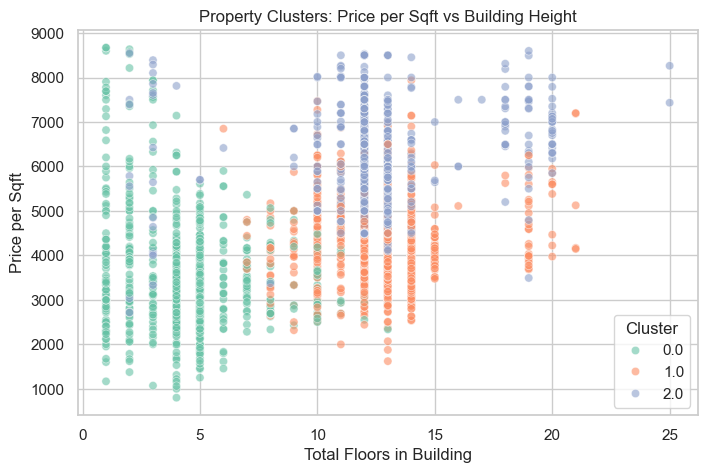

In [18]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="num_floor",
    y="price_per_sqft",
    hue="cluster",
    palette="Set2",
    alpha=0.6
)
plt.title("Property Clusters: Price per Sqft vs Building Height")
plt.xlabel("Total Floors in Building")
plt.ylabel("Price per Sqft")
plt.legend(title="Cluster")
plt.show()

- **Cluster 0**: Exclusively located in buildings with fewer than 10 floors. This suggests that includes both budget-friendly low-rise apartments and high-value properties like Shophouses or Villas, where land value drives the price rather than verticality

- **Cluster 1**: Concentrated in mid-sized buildings (10 to 21 floors). Represents the mass-market or affordable commercial segment. Despite having similar heights to Cluster 2, these properties trade at a significantly lower discount

- **Cluster 2**: Spans from mid-rise (10 floors) to the tallest buildings (25 floors). Represents the premium/luxury segment. The overlap in height with Cluster 1 but separation in price indicates that for buildings above 10 floors, the market bifurcates into "Economy" and "Premium" tiers based on quality or amenities.

## 4. Conclusion & Recommendation

The market is segmented into three distinct regimes:

- **Cluster 0** – “Low-rise Diverse”:
    - This cluster only includes buildings below 10 floors and is clearly separated from the rest of the market. 
    - Prices vary widely, from very low to extremely high, and are not strongly related to height. Instead, value is driven by land factors such as location and property type. 
    - As a result, this cluster combines affordable low-rise housing with high-value assets like villas and shophouses.

- **Cluster 1** – “Mid-rise Economy”:
    - This cluster appears just above the 10-floor threshold and is concentrated around 13–14 floors. 
    - Prices are tightly grouped in the mid-range, showing little variation with height. 
    - It represents the mass-market segment, where units are standardized in size and design, and buyers focus on affordability and practical vertical living rather than luxury.

- **Cluster 2** – “Large-format Luxury”:
    - This cluster overlaps with Cluster 1 in building height but is clearly separated by much larger unit sizes. 
    - It consistently has the highest prices, indicating that premiums are driven by space rather than height alone. 
    - This segment reflects luxury high-rise living, such as penthouses and large-format apartments, where height adds value only when combined with generous floor area.